In [1]:
# Install libraries
%%capture
!pip install tensorflow-probability
!pip install imageio

In [2]:
# Import General Utilities
import numpy as np
import os
import random
from tqdm.notebook import tqdm, trange
import time
import datetime

#Import tensorflow and its requirements
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.datasets as tfds
from tensorflow.data.experimental import cardinality as dlen
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
AUTOTUNE = tf.data.AUTOTUNE

# Import plotting tools and image converters
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import imageio
from IPython import display

# Import file path variable handling
from pathlib import Path
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Constants
batch_size = 32
buffer_size = 500
epochs = 10
img_height = 256
img_width = 256

print(tf.__version__)

2.7.0-dev20210803


In [3]:
# Download OASIS Dataset from the provided link

def download_and_unzip(url, extract_to='.'): # Credit to Antoine Hebert
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)
    http_response.close()

root_dir = '/root/.keras/datasets'

#if Path(root_dir) / 'keras_png_slices_data'
_URL = "https://cloudstor.aarnet.edu.au/plus/s/tByzSZzvvVh0hZA/download"
download_and_unzip(_URL, extract_to=root_dir)
#data_dir = tf.keras.utils.get_file('oasis3', origin=_URL, cache_subdir=root_dir, extract=True)
data_dir = Path(root_dir) / 'keras_png_slices_data'

print(f"Data Directory is {data_dir}")
print(f"Contents: \n\r {os.listdir(data_dir)}")

# Folder Directory Paths
train_dir = data_dir / 'keras_png_slices_train'
train_ans_dir = data_dir / 'keras_png_slices_seg_train'
test_dir = data_dir / 'keras_png_slices_test'
test_ans_dir = data_dir / 'keras_png_slices_seg_test'
val_dir = data_dir / 'keras_png_slices_validate'
val_ans_dir = data_dir / 'keras_png_slices_seg_validate'

Data Directory is \root\.keras\datasets\keras_png_slices_data
Contents: 
 ['keras_png_slices_seg_test', 'keras_png_slices_seg_train', 'keras_png_slices_seg_validate', 'keras_png_slices_test', 'keras_png_slices_train', 'keras_png_slices_validate']


In [4]:
#def count_files(dat_path):
    #return len(list(dat_path.glob('*.*')))

train_ds_list = tf.data.Dataset.list_files(str(train_dir/'*.*'), shuffle=True)
test_ds_list = tf.data.Dataset.list_files(str(test_dir/'*.*'), shuffle=True)
val_ds_list = tf.data.Dataset.list_files(str(val_dir/'*.*'), shuffle=False)

train_ds = train_ds_list.take(dlen(train_ds_list))
test_ds = test_ds_list.take(dlen(test_ds_list))
val_ds = val_ds_list.take(dlen(val_ds_list))

print(f"Train Set is {dlen(train_ds_list)} images, Test Set is {dlen(test_ds_list)} images and Validation Set is {dlen(val_ds_list)} images.")

Train Set is 9664 images, Test Set is 544 images and Validation Set is 1120 images.


In [8]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=1)
    tfimg = tf.image.resize(img, [img_height, img_width])
    tfimg = (tfimg / 255.0) - 0.5 # Normalise data
    # Resize the image to the desired size
    return tfimg

def process_path(file_path):
    #label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [9]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)
val_ds = configure_for_performance(val_ds)

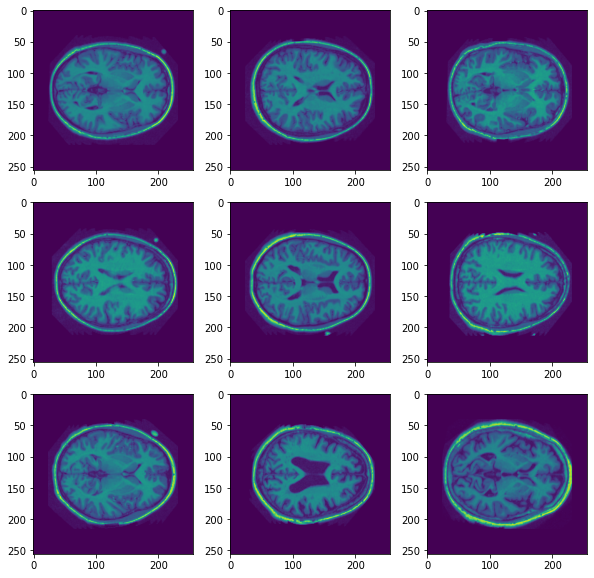

In [10]:
# Show the first scan of 9 patients in the training set
image_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i][:, :, 0])

plt.show()

In [13]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.99, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta  # This parameter is best kept between [0.25, 2] as per the paper.

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


def get_encoder(input_shape=(256, 256, 1), channels=128, strides=4, latent_dim=16, name='encoder'):
    encoder_inputs = Input(shape=input_shape, name=name+'input')

    if strides == 4:
        x = layers.Conv2D(channels // 2, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(channels, 3, activation="relu", strides=2, padding="same")(x)
    elif strides == 2:
        x = layers.Conv2D(channels // 2, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return Model(inputs=encoder_inputs, outputs=encoder_outputs, name="encoder")



def get_decoder(channels=128, strides=4, name='decoder'):
    latent_inputs = Input(shape=get_encoder(strides=strides).output.shape[1:], name=name+'input')

    if strides == 4:
        x = layers.Conv2DTranspose(channels, 3, activation="relu", strides=2, padding="same")(latent_inputs)
        x = layers.Conv2DTranspose(channels // 2, 3, activation="relu", strides=2, padding="same")(x)
    elif strides == 2:
        x = layers.Conv2DTranspose(channels // 2, 3, activation="relu", strides=2, padding="same")(latent_inputs)

    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return Model(inputs=latent_inputs, outputs=decoder_outputs, name="decoder")

In [14]:
def get_vqvae(latent_dim=16, num_embeddings=128):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(channels=num_embeddings)
    decoder = get_decoder(channels=num_embeddings)
    inputs = Input(shape=(256, 256, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
encoder (Functional)         (None, 64, 64, 16)        76560     
_________________________________________________________________
vector_quantizer (VectorQua  (None, 64, 64, 16)        2048      
ntizer)                                                          
_________________________________________________________________
decoder (Functional)         (None, 256, 256, 1)       92929     
Total params: 171,537
Trainable params: 171,537
Non-trainable params: 0
_________________________________________________________________


In [15]:
class VQVAETrainer(tf.keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = tf.keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [24]:
vqvae_trainer = VQVAETrainer(0.03, latent_dim=32, num_embeddings=128)
vqvae_trainer.compile(optimizer=tf.keras.optimizers.Adam())
vqvae_trainer.fit(train_ds, epochs=10, batch_size=256)

Epoch 1/10
302/302 [==============================] - 57s 187ms/step - loss: 1.8177 - reconstruction_loss: 0.4306 - vqvae_loss: 0.7986
Epoch 2/10
302/302 [==============================] - 57s 190ms/step - loss: 0.6247 - reconstruction_loss: 0.1218 - vqvae_loss: 0.4863
Epoch 3/10
302/302 [==============================] - 57s 190ms/step - loss: 0.2749 - reconstruction_loss: 0.0715 - vqvae_loss: 0.1978
Epoch 4/10
302/302 [==============================] - 57s 189ms/step - loss: 0.1337 - reconstruction_loss: 0.0532 - vqvae_loss: 0.0774
Epoch 5/10
302/302 [==============================] - 57s 190ms/step - loss: 0.0958 - reconstruction_loss: 0.0443 - vqvae_loss: 0.0498
Epoch 6/10
302/302 [==============================] - 57s 190ms/step - loss: 0.0805 - reconstruction_loss: 0.0393 - vqvae_loss: 0.0403
Epoch 7/10
302/302 [==============================] - 57s 190ms/step - loss: 0.0723 - reconstruction_loss: 0.0354 - vqvae_loss: 0.0362
Epoch 8/10
302/302 [==============================] - 5

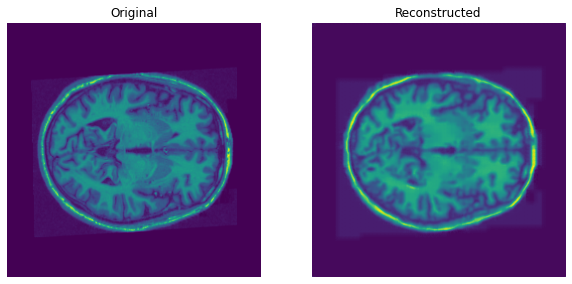

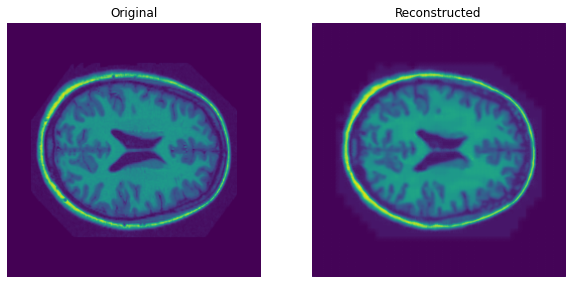

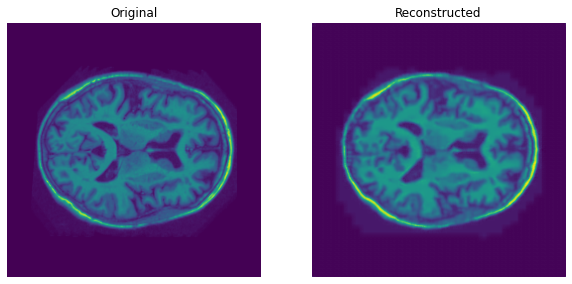

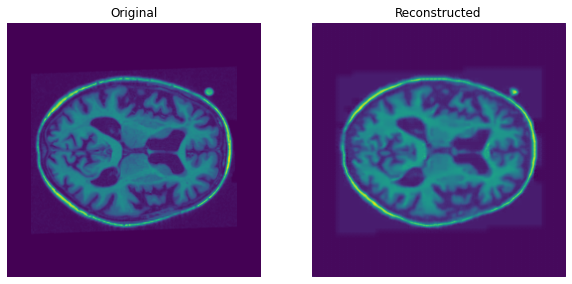

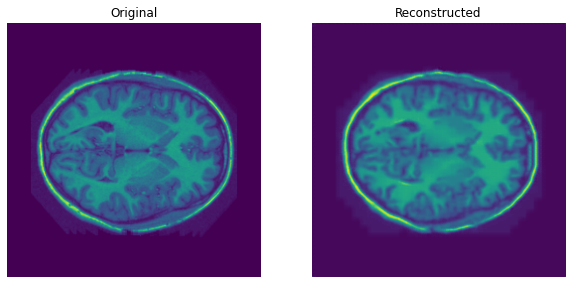

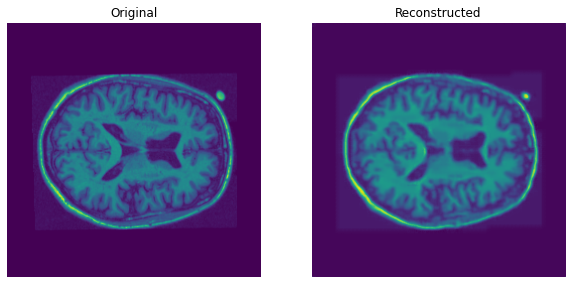

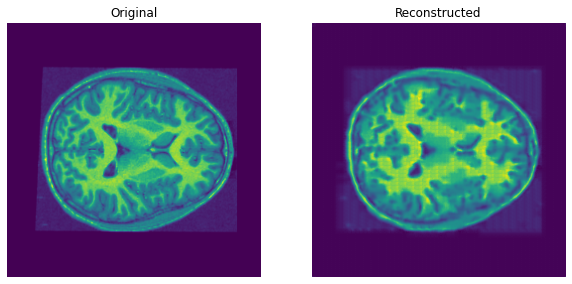

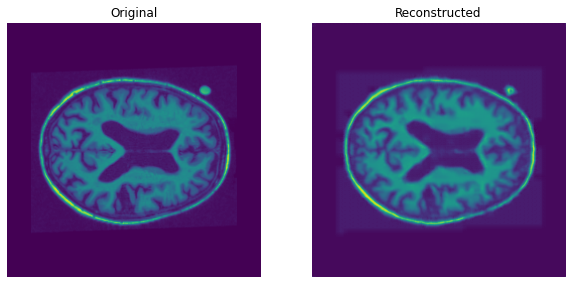

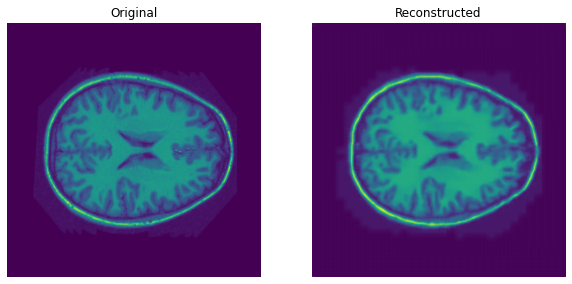

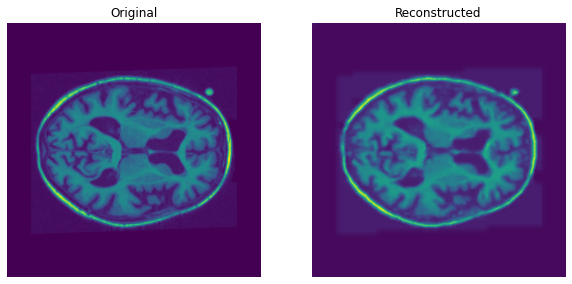

In [43]:
def show_subplot(original, reconstructed):

    original = original + 0.5
    reconstructed = reconstructed + 0.5

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original[:, :, 0])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed[:, :, 0])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
test_images = next(iter(test_ds))
reconstructions_test = trained_vqvae_model.predict(test_images)

for i in range(10):
    show_subplot(test_images[i], reconstructions_test[i])
